## Сбор данных и разработка программного комплекса для классификации контрактов

In [2]:
import os
from os import listdir
from os.path import isfile, join
path = "протоколы_ГосЗакупки_Inter/"

import time
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import trange, tqdm

### Подготовка набора данных

#### Распознавание различных типов документов

In [9]:
import aspose.words as aw
from docx2python import docx2python

from PIL import Image
Image.MAX_IMAGE_PIXELS = 933120000

import easyocr
reader = easyocr.Reader(["ru", "en"]) # this needs to run only once to load the model into memory

from pdf2image import convert_from_path
from PyPDF2 import PdfReader

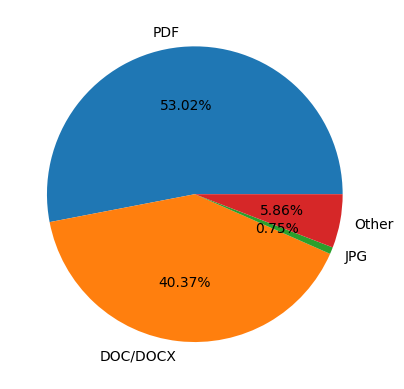

In [10]:
def get_filenames_by_type(files, file_type):
    return [f for f in files if file_type in f]

files = [f for f in listdir(path) if isfile(join(path, f))]

pdf_files = get_filenames_by_type(files, 'pdf')
doc_files = get_filenames_by_type(files, 'doc') # docx included
jpg_files = get_filenames_by_type(files, 'jpg')

approved_files = [len(pdf_files), len(doc_files), len(jpg_files)]
# print(len(files), sum(approved_files))

plt.pie(x = approved_files+[len(files)-sum(approved_files)], 
        labels = ['PDF', 'DOC/DOCX', 'JPG', 'Other'], 
        autopct = lambda x: f"{x:.2f}%");

In [11]:
data_list = []

##### PDF

In [ ]:
for file in tqdm(pdf_files):
    # try OCR
    pages = convert_from_path(path+file, 500)
    content = ''
    for i, page in enumerate(pages):
        page_path = join(path, f"{file.split('.pdf')[0]}_page#{i}.jpg")
        page.save(page_path)
        image = Image.open(page_path)
        result = reader.readtext(image)
        
        for i in range(len(result)):
            content += result[i][1] + ' '
        os.remove(page_path)
    # else just try to read it    
    if content == '' :
        try: 
            reader_for_readable = PdfReader(path + file)
        except Exception as e:
            print(f'{e} at {file}')
            continue
        number_of_pages = len(reader_for_readable.pages)
        content = ''
        for i in range(number_of_pages):
            page = reader_for_readable.pages[i]
            text = page.extract_text()
            content += text
            
    data_list.append(file.split('_')[:2] + [content])

##### DOC/DOCX

In [5]:
# path = 'протоколы_полигон/'
# doc_files = ['5047045359_32211667592_Протокол Пульс.doc', '7805018099_32111000521_протокол закуп у ед поставщ 82-21.docx']

In [12]:
for file in tqdm(doc_files):
    if '.pdf' in file:
        continue
    
    txt_path = f"{path + file.split('.doc')[0]}.txt"
    if 'docx' in file:
        # extract docx content
        with docx2python(path + file) as docx_content:
            content = docx_content.text
    else:
        # Load DOC file
        doc = aw.Document(path + file)

        # Save DOC as TXT
        doc.save(txt_path)
        
        with open(txt_path, encoding="utf8") as f:
            content = f.read()
        os.remove(txt_path)
    content = content.replace("Evaluation Only. Created with Aspose.Words. Copyright 2003-2023 Aspose Pty Ltd.", '')
    content = content.replace("Created with an evaluation copy of Aspose.Words. To discover the full versions of our APIs please visit: https://products.aspose.com/words/", '')
    data_list.append(file.split('_')[:2] + [content])

  0%|          | 0/861 [00:00<?, ?it/s]

D:\!edu\Data_Science\ds_edu_venv\lib\site-packages\docx2python\bullets_and_numbering.py:47: UserWarning: none numbering format not implemented, substituting '--'
  warnings.warn(
D:\!edu\Data_Science\ds_edu_venv\lib\site-packages\docx2python\bullets_and_numbering.py:47: UserWarning: russianLower numbering format not implemented, substituting '--'
  warnings.warn(


##### JPG

In [28]:
for file in tqdm(jpg_files):
    # Загрузка изображения с текстом
    image = Image.open(path + file)
    result = reader.readtext(image)
    content = ''
    for i in range(len(result)):
        content += result[i][1] + ' '
        
    data_list.append(file.split('_')[:2] + [content])

##### Сохранение результатов

In [13]:
data = pd.DataFrame(data_list, columns=['INN', 'id', 'Content'])
display(data.head(3))
data.to_csv('contracts_recognized_v0.1.csv', index=False)

,INN,id,Content
0,1435028701,32211077961,﻿\n\n\tПРОТОКОЛ № 01-01/ПЗ\tЗАСЕДАНИЯ КОМИССИИ...
1,1600000036,32009623697,﻿\n\n\n\t\t\t\t\t\t\t\t\n\nПротокол по закупке...
2,1644003838,32009178231,УТВЕРЖДАЮ\n\nДиректор\n\nООО «НижнекамскаяТЭЦ»...


#### Цены

In [20]:
import requests
from bs4 import BeautifulSoup

In [16]:
data = pd.read_csv('contracts_recognized_v0.1.csv')
data.head(3)

,INN,id,Content
0,1435028701,32211077961,﻿\n\n\tПРОТОКОЛ № 01-01/ПЗ\tЗАСЕДАНИЯ КОМИССИИ...
1,1600000036,32009623697,﻿\n\n\n\t\t\t\t\t\t\t\t\n\nПротокол по закупке...
2,1644003838,32009178231,УТВЕРЖДАЮ\n\nДиректор\n\nООО «НижнекамскаяТЭЦ»...


In [18]:
# получение списка id закупок для краулинга цены по ним
id_list = data['id'].values.tolist()

In [1]:
url = 'https://zakupki.kontur.ru/'
price_list = []
for id_ in id_list:
    page = requests.get(url+str(id_))
    soup = BeautifulSoup(page.text, "lxml")
    try:
        price = soup.find('div', class_='tender-named-values_value').find('span').text.strip()
    except AttributeError:
        price = np.nan
    print(f'id: {id_}, status: {page.status_code}, price: {price}')
    price_list.append(price)
    time.sleep(1)
data['Price'] = price_list
data.head(3)

In [ ]:
data.to_csv('contracts_recognized_price_v0.1.csv', index=False)

#### Предобработка данных

In [25]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords = stopwords.words('russian')

import pymorphy2 # библиотека для лемматизации русских слов
morph = pymorphy2.MorphAnalyzer()

from razdel import tokenize

[nltk_data] Downloading package punkt to C:\Users\immortal-
[nltk_data]     qQ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\immortal-
[nltk_data]     qQ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
file = "contracts_recognized_price_v0.1.csv"
data = pd.read_csv(file)
data.head(3)

,INN,id,Content,Price
0,1650131524,32110319284,АКЦИОНЕРНОЕ ОБЩЕСТВО кМарийЭл (МАРИЙ ЭЛ ДОРСТР...,"2 794 900,00 ₽"
1,2308091759,32009803537,ПРОТОКОЛ Ngl4 Заседания Комиссии по осуществле...,"588 900,00 ₽"
2,2308119595,32211019865,Ha заседании отсутствует секретарь комиссии А....,"3 900 000,00 ₽"


##### Удаление nan-значений, возникших распознавании текстов или парсинге цены

In [27]:
data.isna().sum()

INN         0
id          0
Content    20
Price      16
dtype: int64

In [28]:
data.dropna(axis=0, how='any', inplace=True)
data.reset_index(drop=True, inplace=True)
data.isna().sum()

INN        0
id         0
Content    0
Price      0
dtype: int64

##### Предобработка текстов контрактов

In [29]:
def preprocess_text(text: str):
    text = text.lower()
    text = re.sub(r'([^А-Яа-я.,!?])', ' ', text)
    tokenized_text = list(tokenize(text))
    cleaned_text = ''
    for word in tokenized_text:
        # лемматизация
        cleaned_word = morph.parse(word.text)[0].normal_form
        # удаление стоп-слов и случайно распознавшихся одиночных символов
        if not cleaned_word in stopWords and len(cleaned_word) > 1:
            cleaned_text += cleaned_word + ' '
    return cleaned_text

In [30]:
data.loc[:, 'Content'] = data['Content'].apply(lambda x: preprocess_text(x))
data.head(3)

,INN,id,Content,Price
0,1650131524,32110319284,акционерный общество кмарийэла марий эл дорстр...,"2 794 900,00 ₽"
1,2308091759,32009803537,протокол заседание комиссия осуществление заку...,"588 900,00 ₽"
2,2308119595,32211019865,заседание отсутствовать секретарь комиссия раз...,"3 900 000,00 ₽"


##### Предобработка цен контрактов

In [31]:
exch_rate = 77
prepr_price = []
for price in tqdm(data.loc[:, 'Price']):
    price = price.replace(' ', '')
    price = price.replace(',', '.')
    if price[-1] == '$':
        prepr_price.append(exch_rate * float(price[:-1]))
    else:
        prepr_price.append(float(price[:-1]))
    
data.drop(['Price'], axis=1, inplace=True)
data['Price'] = np.array(prepr_price)
data.head(3)

  0%|          | 0/1901 [00:00<?, ?it/s]

,INN,id,Content,Price
0,1650131524,32110319284,акционерный общество кмарийэла марий эл дорстр...,2794900.0
1,2308091759,32009803537,протокол заседание комиссия осуществление заку...,588900.0
2,2308119595,32211019865,заседание отсутствовать секретарь комиссия раз...,3900000.0


##### Удаление "выбросов" - договоров, текст которых слишком мал / велик

In [32]:
calc_len = data['Content'].apply(lambda x: len(list(tokenize(x))))
data['Content'][116], calc_len[116]

('широта широта широта ', 3)

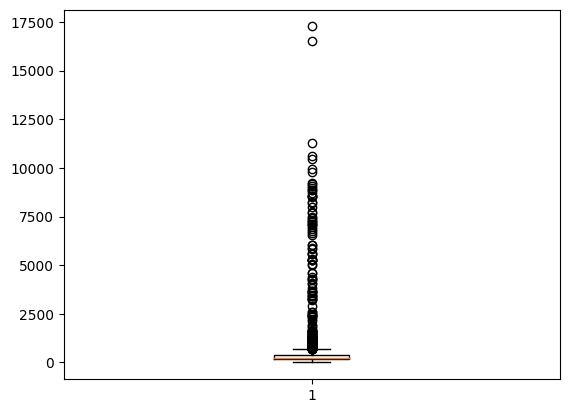

In [33]:
plt.boxplot(calc_len);

In [34]:
mn = calc_len.quantile(0.01)
mx = calc_len.quantile(0.8)
print(f'Минимально / Максимальная допустимая длина договора:\n{mn:.2f} / {mx:.2f}')
mask = ((calc_len <= mx) & (calc_len >= mn))

print(f'Процент отобранных для обучения значений: {mask.sum() / calc_len.shape[0] * 100:.2f}%')
data = data[mask].copy(deep=True)
data.reset_index(drop=True, inplace=True)
data.head(3)

Минимально / Максимальная допустимая длина договора:
6.00 / 430.00
Процент отобранных для обучения значений: 79.17%


,INN,id,Content,Price
0,1650131524,32110319284,акционерный общество кмарийэла марий эл дорстр...,2794900.0
1,2308091759,32009803537,протокол заседание комиссия осуществление заку...,588900.0
2,2308119595,32211019865,заседание отсутствовать секретарь комиссия раз...,3900000.0


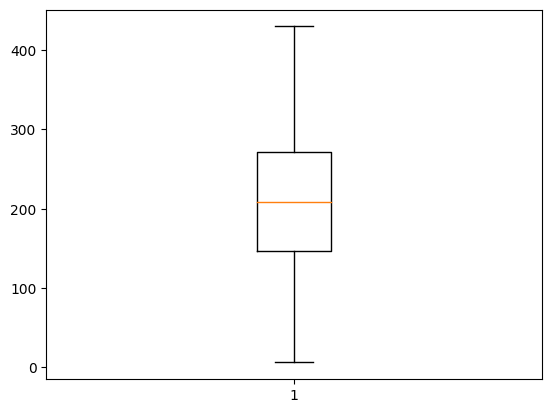

In [35]:
calc_len = data['Content'].apply(lambda x: len(list(tokenize(x))))
plt.boxplot(calc_len);

##### Сохранение

In [36]:
data.to_csv('contracts_recognized_price_preprocessed_v0.1.csv', index=False)

#### Выделение целевой переменной

In [37]:
file = "contracts_recognized_price_preprocessed_v0.1.csv"
data = pd.read_csv(file)
data.head(3)

,INN,id,Content,Price
0,1650131524,32110319284,акционерный общество кмарийэла марий эл дорстр...,2794900.0
1,2308091759,32009803537,протокол заседание комиссия осуществление заку...,588900.0
2,2308119595,32211019865,заседание отсутствовать секретарь комиссия раз...,3900000.0


In [41]:
bin_labels = ['Low', 'Medium', 'High', 'Extremly high']

data['Target'], bins = pd.qcut(data['Price'], q=4, labels = bin_labels, retbins=True)
display(data.head(3))
['{:.2f}'.format(i) for i in bins]

,INN,id,Content,Price,Target
0,1650131524,32110319284,акционерный общество кмарийэла марий эл дорстр...,2794900.0,High
1,2308091759,32009803537,протокол заседание комиссия осуществление заку...,588900.0,Medium
2,2308119595,32211019865,заседание отсутствовать секретарь комиссия раз...,3900000.0,High


['0.11', '385123.00', '1225900.00', '5000000.00', '9236295744.06']

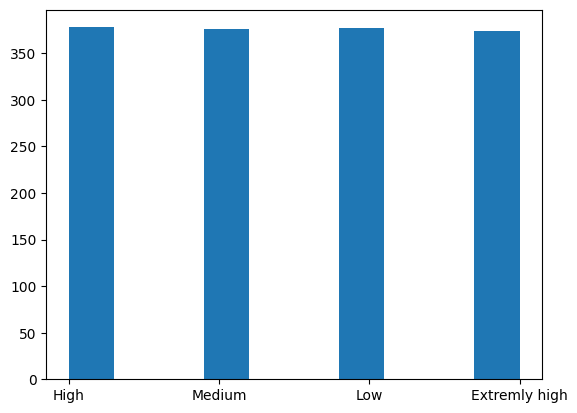

In [42]:
plt.hist(data['Target']);

In [43]:
data.to_csv('contracts_recognized_price_preprocessed_target_v0.1.csv', index=False)

### Обучение моделей классификации с использованием CNN и RNN

In [52]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from navec import Navec
from razdel import tokenize

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns 

In [45]:
file = "contracts_recognized_price_preprocessed_target_v0.1.csv"
data = pd.read_csv(file)
data.head(3)

,INN,id,Content,Price,Target
0,1650131524,32110319284,акционерный общество кмарийэла марий эл дорстр...,2794900.0,High
1,2308091759,32009803537,протокол заседание комиссия осуществление заку...,588900.0,Medium
2,2308119595,32211019865,заседание отсутствовать секретарь комиссия раз...,3900000.0,High


#### Создание класса Vocab

In [48]:
class Vocab:
    def __init__(self, data: pd.DataFrame(), target_col: str, feature_col: str):
        self.idx_to_token = {key: value for key, value in enumerate(data[target_col].unique().tolist())}
        self.token_to_idx = dict(zip(self.idx_to_token.values(), self.idx_to_token.keys()))
        self.vocab_len = data[target_col].nunique()
        self.max_contract_length = data[feature_col].astype('str').apply(lambda x: len(list(tokenize(x)))).max()

In [49]:
vocabulary = Vocab(data = data, target_col='Target', feature_col = 'Content')
print(f"Количество классов для предсказания: {vocabulary.vocab_len}")
print(f"Максимальная длина контракта: {vocabulary.max_contract_length}")
print(vocabulary.token_to_idx)
print(vocabulary.idx_to_token)

Количество классов для предсказания: 4
Максимальная длина контракта: 430
{'High': 0, 'Medium': 1, 'Low': 2, 'Extremly high': 3}
{0: 'High', 1: 'Medium', 2: 'Low', 3: 'Extremly high'}


#### Разбиение на обучающую и тестовую выборки

((1204,), (301,))

((1204,), (301,))

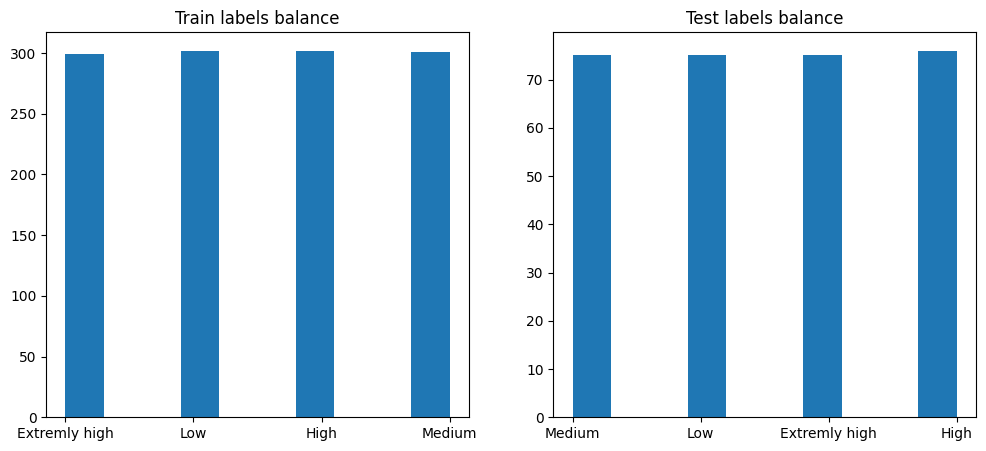

In [55]:
X = data.iloc[:, 2].values
y = data.iloc[:, 4].astype(str).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
display((X_train.shape, X_test.shape), (y_train.shape, y_test.shape))

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 5), squeeze=False)
ax[0][0].hist(y_train)
ax[0][0].set_title('Train labels balance')
ax[0][1].hist(y_test)
ax[0][1].set_title('Test labels balance');

#### Формирование словаря на основе только обучающей выборки

In [59]:
dictionary = set()
for x in tqdm(X_train):
    dictionary.update([_.text for _ in list(tokenize(x))])
    
dictionary = np.array(list(dictionary)) # уникальные слова
np.random.shuffle(dictionary)
dictionary = np.concatenate((np.array(['<PAD>', '<UNK>']), dictionary), axis=None) # добавляем токены <PAD> и <UNK>
print(len(dictionary), '\n', dictionary[0:5], sep='')

  0%|          | 0/1204 [00:00<?, ?it/s]

15161
['<PAD>' '<UNK>' 'корона' 'рвс' 'труппа']


#### Описание класса ContractDataset

In [60]:
class ContractDataset(Dataset):
    def __init__(self, X, y, vocab: Vocab, dictionary):
        self.X = X
        self.y = y
        self.vocab = vocab
        self.dictionary = dictionary

    def vectorize(self, contract):
        '''Генерирует представление контракта в виде последовательности индексов токенов'''
        sequence = []
        for word in [_.text for _ in list(tokenize(contract))]: 
            indx = np.where(word == dictionary)[0]
            if indx.size == 0:
                sequence.append(1)
            else:
                sequence.append(indx.item())
        for i in range(len(sequence), self.vocab.max_contract_length):
            sequence.append(0)
        # sequence = torch.tensor(sequence, dtype=torch.float32)
        sequence = torch.tensor(sequence).type(torch.LongTensor)
        return sequence

    def __len__(self): # количество примеров в выборке
        return len(self.X)

    def __getitem__(self, idx): # абсолютный индекс
        return self.vectorize(self.X[idx]), self.vocab.token_to_idx[self.y[idx]]

In [61]:
train_dataset = ContractDataset(X_train, y_train, vocabulary, dictionary)
test_dataset = ContractDataset(X_test, y_test, vocabulary, dictionary)
print(len(train_dataset), len(test_dataset))
trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

1204 301


#### Загрузка предобученных эмбеддингов

In [63]:
def get_emb_matrix(word_embeddings, dictionary, emb_size = 300):
    """ Creates embedding matrix from word vectors"""
    dict_size = dictionary.shape[0]
    W = np.zeros((dict_size, emb_size), dtype="float32")
    W[0] = np.zeros(emb_size, dtype='float32')
    W[1] = np.random.uniform(-0.25, 0.25, emb_size) 
    i = 2
    appl = 0
    for word in dictionary[2:]:
        if word in word_embeddings:
            W[i] = word_embeddings[word]
            appl += 1
        else:
            W[i] = np.random.uniform(-0.25, 0.25, emb_size)
        i += 1   
    print(f"Доля встретившихся слов: {appl / dict_size}")
    return W

path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

pretrained_weights = get_emb_matrix(navec, dictionary)

Доля встретившихся слов: 0.4239825869006002


#### Архитектура модели

In [67]:
class LSTM_navec_weights(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, navec_weights) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embeddings.weight.data.copy_(torch.from_numpy(navec_weights))
        self.embeddings.weight.requires_grad = False 
        self.emb_dropout = nn.Dropout1d(p=0.3)
        
        self.conv = nn.Conv1d(430, hidden_dim, 5)
        self.relu1 = nn.ReLU()
        
        self.bn = nn.BatchNorm1d(hidden_dim)
       
        
        self.lstm = nn.LSTM(296, hidden_dim, bidirectional=True, num_layers = 2, dropout=0.2, batch_first=True) 
        
        self.lstm_bn = nn.BatchNorm1d(hidden_dim)
        self.lstm_dropout = nn.Dropout(0.5)
            
        self.linear1 = nn.Linear(hidden_dim, 512)
        self.relu2 = nn.ReLU()
        
        self.bn3 = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(0.5)
        
        self.linear2 = nn.Linear(512, 512)
        self.relu3 = nn.ReLU()
        
        self.out_bn = nn.BatchNorm1d(512)
        self.out_dropout = nn.Dropout(0.5)
        
        self.linear3 = nn.Linear(512, 4)
        
    def forward(self, x):
        x = self.embeddings(x) # batch x contract_len x embedding_dim
        x = self.emb_dropout(x)
        
        x = self.relu1(self.conv(x)) # batch x hidden_size x 296
        
        x = self.bn(x)
        
        lstm_out, (ht, ct) = self.lstm(x)
        x = ht[-1] # batch x hidden_size
        
        x = self.lstm_bn(x)
        x = self.lstm_dropout(x)
        
        x = self.relu2(self.linear1(x)) # batch x 512
        
        x = self.bn3(x)
        x = self.dropout3(x)
        
        x = self.relu3(self.linear2(x)) # batch x 512
        x = self.out_bn(x)
        x = self.out_dropout(x)
        
        x = self.linear3(x) # batch x 4
        return x

#### Train loop

In [78]:
def fit(model, loaders, criterion, optimizer, lr_scheduler=None, epochs=10, plot = True, device = 'cpu'):
    losses = {"train": [], "valid": []}
    accuracy = {"train": [], "valid": []}
    
    for epoch in trange(epochs):
        print(f"Epoch #{epoch}")
        for loader_type, dataloader in loaders.items():
            epoch_losses = []
            y_true, y_pred = [], []
            for x_batch, y_batch in dataloader:
                y_true.extend(y_batch.tolist())
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                
                # предсказания в зависимости от типа загрузчика
                if loader_type == "train":
                    model.train()
                    optimizer.zero_grad()
                    pred = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        pred = model(x_batch)
                
                pred_classes = torch.argmax(pred, 1).tolist()
                y_pred.extend(pred_classes)
                
                if loader_type == 'train':
                    loss = criterion(pred, y_batch)
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        loss = criterion(pred, y_batch)
                epoch_losses.append(loss.item())
                    
            epoch_acc = accuracy_score(np.array(y_true), np.array(y_pred))
            print(f"Accuracy {loader_type}: {epoch_acc:.2f}")
            print(f"F1-score {loader_type}: {f1_score(np.array(y_true), np.array(y_pred), average='weighted'):.2f}")
            accuracy[loader_type].append(epoch_acc)
            losses[loader_type].append(np.array(epoch_losses).mean())
        if lr_scheduler is not None:
            lr_scheduler.step()
    if plot:
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 5), squeeze=False)
        ax[0][0].set_title('Loss')
        ax[0][0].plot(losses['train'], label='Train losses')
        ax[0][0].plot(losses['valid'], label='Valid losses')
        ax[0][0].legend()
        
        ax[0][1].set_title('Accuracy')
        ax[0][1].plot(accuracy['train'], label='Train accuracy')
        ax[0][1].plot(accuracy['valid'], label='Valid accuracy')
        ax[0][1].legend()
        plt.show();

#### Обучение модели

In [66]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Current device: {device}")

Current device: cuda


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #0
Accuracy train: 0.28
F1-score train: 0.28
Accuracy valid: 0.26
F1-score valid: 0.22
Epoch #1
Accuracy train: 0.29
F1-score train: 0.29
Accuracy valid: 0.32
F1-score valid: 0.27
Epoch #2
Accuracy train: 0.31
F1-score train: 0.31
Accuracy valid: 0.31
F1-score valid: 0.28
Epoch #3
Accuracy train: 0.34
F1-score train: 0.34
Accuracy valid: 0.27
F1-score valid: 0.23
Epoch #4
Accuracy train: 0.38
F1-score train: 0.38
Accuracy valid: 0.37
F1-score valid: 0.37
Epoch #5
Accuracy train: 0.39
F1-score train: 0.38
Accuracy valid: 0.36
F1-score valid: 0.36
Epoch #6
Accuracy train: 0.43
F1-score train: 0.43
Accuracy valid: 0.38
F1-score valid: 0.38
Epoch #7
Accuracy train: 0.43
F1-score train: 0.43
Accuracy valid: 0.40
F1-score valid: 0.40
Epoch #8
Accuracy train: 0.47
F1-score train: 0.46
Accuracy valid: 0.40
F1-score valid: 0.40
Epoch #9
Accuracy train: 0.51
F1-score train: 0.51
Accuracy valid: 0.41
F1-score valid: 0.41


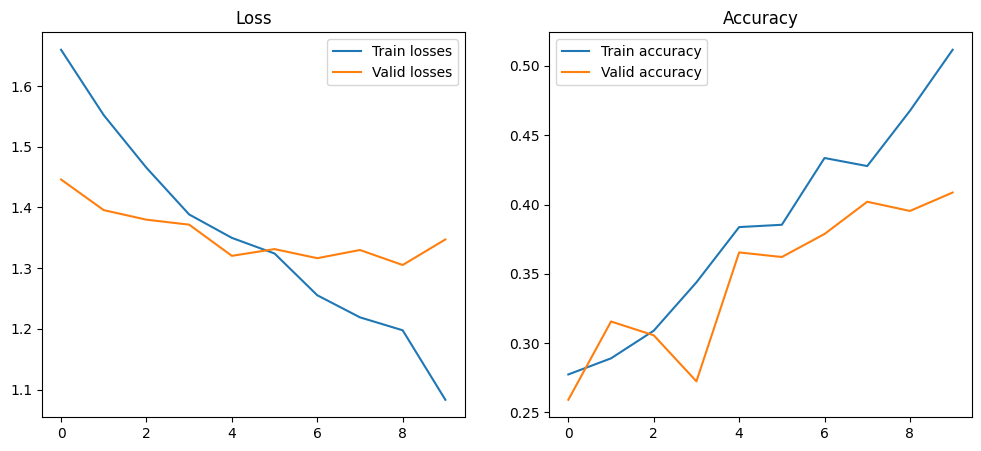

In [79]:
loaders = {"train": trainloader, "valid": testloader}
model = LSTM_navec_weights(len(dictionary), 300, 64, pretrained_weights).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

fit(model,
    loaders,
    nn.CrossEntropyLoss(),
    optimizer,
    lr_scheduler,
    10,
    True,
    device)

### Оценка качества моделей и сравнение результатов

In [81]:
def get_pred(dataloader, model, device):
    y_true, y_pred = [], []
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            y_true.extend(y_batch.tolist())
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred = model(x_batch)
            pred_classes = torch.argmax(pred, 1).tolist()
            y_pred.extend(pred_classes)
    return np.array(y_true), np.array(y_pred)  

Accuracy train: 0.67
Accuracy test: 0.41


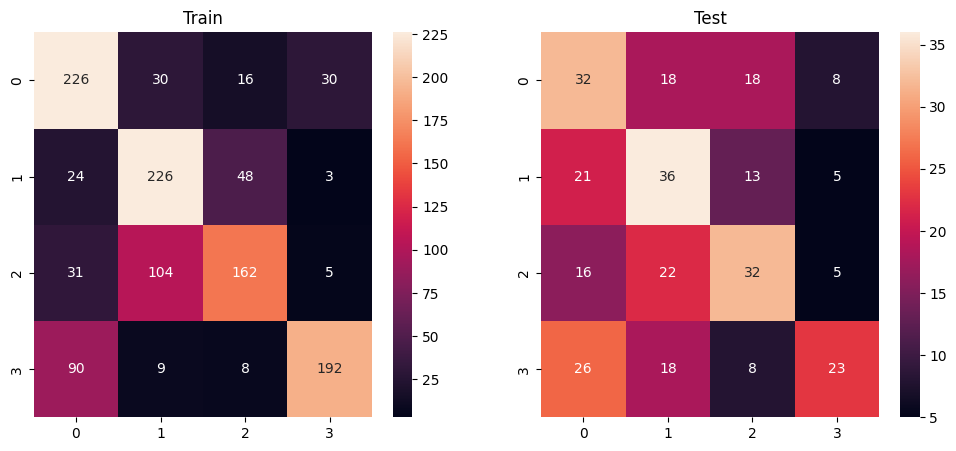

In [82]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 5), squeeze=False)

model.eval()

# train
true, predict = get_pred(trainloader, model, device)
print(f"Accuracy train: {accuracy_score(true, predict):.2f}")
# print(f"F-score train: {f1_score(true, predict, average='weighted'):.2f}")

sns.heatmap(confusion_matrix(true, predict), annot=True, fmt='g', ax=ax[0][0]);
ax[0][0].set_title('Train');

# test
true, predict = get_pred(testloader, model, device)
print(f"Accuracy test: {accuracy_score(true, predict):.2f}")
# print(f"F-score test: {f1_score(true, predict, average='weighted'):.2f}")

sns.heatmap(confusion_matrix(true, predict), annot=True, fmt='g', ax=ax[0][1]);
ax[0][1].set_title('Test');